# Optimal probabilistic clustering - Part II
> ...

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Clustering, Entropy, Membership Entropy]
- image: images/post_image_optimal_clustering.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

In [29]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import cdist

class OPC:
    def __init__(self, n_clusters=10, max_iter=150, m=2, error=1e-5, random_state=42):
        self.u, self.centers = None, None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state

    def fit(self, X, initial_centers=None):
        N = X.shape[0]
        C = self.n_clusters
        centers = initial_centers

        # u = np.random.dirichlet(np.ones(C), size=N)
        r = np.random.RandomState(self.random_state)
        u = r.rand(N,C)
        u = u / np.tile(u.sum(axis=1)[np.newaxis].T,C)

        iteration = 0
        while iteration < self.max_iter:
            u2 = u.copy()
            
            if iteration==0 and not centers is None:
                centers = centers
            else:
                centers = self.next_centers(X, u)
                
            u = self.next_u(X, centers)
            iteration += 1

            # Stopping rule
            if norm(u - u2) < self.error:
                break

        self.u = u
        self.centers = centers
        return self

    def next_centers(self, X, u):
        um = u ** self.m
        return (X.T @ um / np.sum(um, axis=0)).T

    def next_u(self, X, centers):
        return self._predict(X, centers)

    def _predict(self, X, centers):
        power = float(2 / (self.m - 1))
        temp = cdist(X, centers) ** power
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_

        return 1 / denominator_.sum(2)

    def predict(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)

        u = self._predict(X, self.centers)
        return np.argmax(u, axis=-1)

In [30]:
######################################## Part I

def run_cluster(n_clusters, data, initial_centers=None, random_state=42):
    # membership probabilities
    model = OPC(n_clusters=n_clusters, random_state=random_state, max_iter=1000, error=1e-9)
    model = model.fit(data, initial_centers=initial_centers)
    p = model.u
    centers = model.centers
    # representative cluster
    representative_cluster = np.argmax(p, 1)
    # membership entropy
    Sx = -np.sum(p*np.log(p), 1) / np.log(n_clusters)
    # total membership entropy (across the entire feature space)
    S = np.sum(Sx)        
    
    return centers, p, representative_cluster, Sx, S



Check if I'm introducing a regularization in inferring the optimal number of clusters

In [103]:
lamb = 1.0

## Experimental results

In [104]:
import numpy as np

(n,k,m) n observations, k clusters, at least m observations per cluster

In [147]:
def construct_random_partition(n, k, m, seed=None):
    rand = np.random.RandomState(seed=seed)
    parts = rand.choice(range(1, n-k*(m-1)), k-1, replace=False)
    parts.sort()
    parts = np.append(parts, n-k*(m-1))
    parts = np.append(parts[0], np.diff(parts)) - 1 + m
    
    return parts

In [158]:
partition = construct_random_partition(n=500, k=7, m=2, seed=40)
print(partition)

[153  75  13  33   7  36 183]


**Generation of random datasets**

In [159]:
def generate_random_dataset(partition, n_features, std, seed):
    random_state = np.random.RandomState(seed=seed)
    dataset = list()
    for n in partition:
        # cluster centre coordinates
        cluster_centre = random_state.uniform(-1, 1, n_features)
        # observation coordinates
        for observation in range(0, n):
            dataset.append(cluster_centre+std*random_state.standard_normal(n_features))
    dataset = np.array(dataset)
    # shuffles the observations
    dataset = dataset[random_state.permutation(dataset.shape[0]), :]
    
    return np.array(dataset)

In [160]:
dataset = generate_random_dataset(partition=partition, n_features=2, std=0.10, seed=11)

We will, at each iteration, collect the mean-intracluster entropy

In [161]:
Si = list()
iteration = 0
centers = None
n_clusters_trials = np.arange(2, 12, 1)

Some helpful functions

In [162]:
### Minimization of membership entropy
def minimize_membership_entropy(n_clusters_trials, dataset, lamb=0, random_state=42, n_seed=1):

    # Creates the seeds
    if n_seed == 1:
        seeds = np.array([random_state])
    else:
        seeds = np.random.randint(low=1, high=1e9, size=n_seed)
        
    # Runs the clustering for different seeds and number of clusters
    total_entropies = list()
    
    for seed in seeds:
        total_entropies_ = list()
        for trial in n_clusters_trials:
            _, _, _, _, total_entropy = run_cluster(n_clusters=trial, 
                                                    data=dataset, 
                                                    random_state=seed)
            total_entropies_.append(total_entropy+lamb*trial)
        total_entropies.append(total_entropies_)
    total_entropies = np.array(total_entropies)
        
    # Finds the optimal number of clusters and the respective seed
    location = np.argwhere(total_entropies == np.min(total_entropies))[0]
    optimal_seed = seeds[location[0]]
    optimal_nclusters = n_clusters_trials[location[1]]
    
    
    return optimal_seed, optimal_nclusters, total_entropies
    
    
### Cluster quality
def calculate_cluster_quality(p, representative_cluster, PRINT=True):
    Si = dict()
    for clust in set(representative_cluster):
        probs = p[np.argmax(p, 1)==clust, :]
        entropy = -np.sum(probs*np.log(probs), 1) / np.log(probs.shape[1])
        Si.update({clust: np.mean(entropy)})

    if PRINT:
        [print("Mean membership entropy across cluster {0} = {1}".format(i, np.round(Si[i], 3))) for i in Si.keys()]
        
    return Si

### Iteration 1

**1.1) Minimization of membership entropy**

In [163]:
optimal_seed, optimal_nclusters, total_entropies = minimize_membership_entropy(n_clusters_trials, 
                                                                               dataset, 
                                                                               lamb, 
                                                                               n_seed=100)
print("Optimal number of clusters =", optimal_nclusters)

Optimal number of clusters = 2


**1.2) Clustering**

In [164]:
centers, p, representative_cluster, Sx, S = run_cluster(optimal_nclusters, dataset, random_state=optimal_seed)
print("Total membership entropy =", np.round(S, 2))

Total membership entropy = 132.51


**1.3) Cluster quality**

In [165]:
Si.append(calculate_cluster_quality(p, representative_cluster))

Mean membership entropy across cluster 0 = 0.152
Mean membership entropy across cluster 1 = 0.32


**1.4) Plot**

In [166]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt

def make_rgb_transparent(rgb, alpha):
    bg_rgb = [1, 1, 1]
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]
colormap = cm.get_cmap('Accent')

edgecolors = list()
facecolors = list()
for i in range(0, optimal_nclusters):
    edgecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=1))
    facecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=0.65))

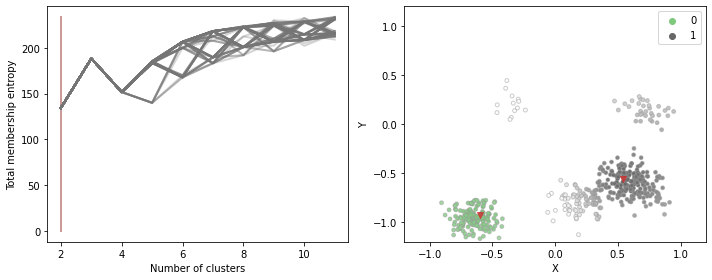

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot([optimal_nclusters, optimal_nclusters], [0, np.max(total_entropies)], color=(0.8,0.6,0.6), linewidth=2)
for i in range(0, total_entropies.shape[0]):
    axes[0].plot(n_clusters_trials, total_entropies[i,:], color=(0.46,0.46,0.46,0.3), linewidth=2)
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Total membership entropy')

color_seq = list()
for j in range(0, dataset.shape[0]):
    color_seq.append(make_rgb_transparent(edgecolors[representative_cluster[j]], 1-Sx[j]))
for i in range(0, optimal_nclusters):
    axes[1].scatter([], [], label=str(i), color=edgecolors[i])
axes[1].scatter(dataset[:,0], dataset[:,1], marker='.', s=60, edgecolors=(0.6,0.6,0.6,0.5), c=color_seq)
axes[1].scatter(centers[:,0], centers[:,1], color=(0.8,0.2,0.2, 0.8), marker="v")
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_xlim(-1.2,1.2)
axes[1].set_ylim(-1.2,1.2)
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

**1.5) Finds clusters with an below-average mean membership entropy**

In [168]:
print("Intra-cluster mean membership entropy")
Si[iteration]

Intra-cluster mean membership entropy


{0: 0.1517563457407526, 1: 0.32029601152984294}

In [169]:
n_collect = 1

In [170]:
best_clusters = np.array(list(Si[iteration].keys()))[np.argsort(list(Si[iteration].values()))[0:(iteration+1)*n_collect]]
print("Best clusters -> ", best_clusters)

Best clusters ->  [0]


In [171]:
remaining_clusters = np.array(list(set(Si[iteration].keys()).difference(set(best_clusters))))
print("Remaining clusters -> ", remaining_clusters)

Remaining clusters ->  [1]


In [172]:
center_best_clusters = centers[best_clusters,:]

**1.6) Collects observations from the remaining clusters**

In [173]:
inds = []
for cluster in remaining_clusters:
    inds += list(np.where(representative_cluster==cluster)[0])
inds = np.squeeze(np.array(inds))

dataset_remaining_clusters = dataset[inds,:]

In [174]:
optimal_seed, optimal_nclusters, total_entropies = minimize_membership_entropy(n_clusters_trials, 
                                                                               dataset_remaining_clusters, 
                                                                               lamb, 
                                                                               n_seed=100)
print("Optimal number of clusters =", optimal_nclusters)

Optimal number of clusters = 3


In [175]:
new_centers, p, representative_cluster, Sx, S = run_cluster(optimal_nclusters, 
                                                            dataset_remaining_clusters,
                                                            random_state=optimal_seed)

In [176]:
trial_centers = np.vstack((center_best_clusters, new_centers))

In [177]:
centers, p, representative_cluster, Sx, S = run_cluster(trial_centers.shape[0], 
                                                        dataset, 
                                                        initial_centers=trial_centers, 
                                                        random_state=optimal_seed)
print("Total membership entropy =", np.round(S, 2))

Total membership entropy = 147.77


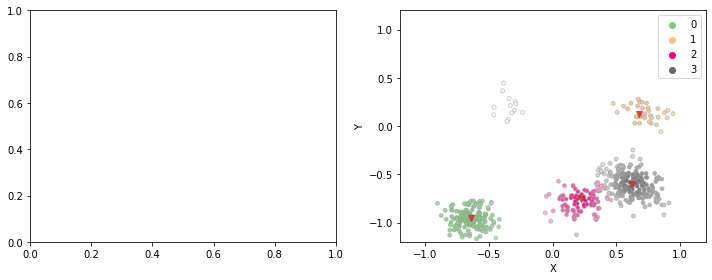

In [178]:
optimal_nclusters = centers.shape[0]

edgecolors = list()
facecolors = list()
for i in range(0, optimal_nclusters):
    edgecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=1))
    facecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=0.65))
    
    
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

color_seq = list()
for j in range(0, dataset.shape[0]):
    color_seq.append(make_rgb_transparent(edgecolors[representative_cluster[j]], 1-Sx[j]))
for i in range(0, optimal_nclusters):
    axes[1].scatter([], [], label=str(i), color=edgecolors[i])
axes[1].scatter(dataset[:,0], dataset[:,1], marker='.', s=60, edgecolors=(0.6,0.6,0.6,0.5), c=color_seq)

axes[1].scatter(centers[:,0], centers[:,1], color=(0.8,0.2,0.2, 0.8), marker="v")

axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_xlim(-1.2,1.2)
axes[1].set_ylim(-1.2,1.2)
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

Total entropy is smaller than previous minimized entropy. Move to next iteration

### Iteration 2

In [48]:
iteration += 1

In [49]:
Si.append(calculate_cluster_quality(p, representative_cluster))

Mean membership entropy across cluster 0 = 0.047
Mean membership entropy across cluster 1 = 0.147
Mean membership entropy across cluster 2 = 0.226
Mean membership entropy across cluster 3 = 0.054
Mean membership entropy across cluster 4 = 0.139
Mean membership entropy across cluster 5 = 0.194


In [50]:
best_clusters = np.array(list(Si[iteration].keys()))[np.argsort(list(Si[iteration].values()))[0:iteration+1]]
print("Best clusters -> ", best_clusters)

Best clusters ->  [0 3]


In [51]:
remaining_clusters = np.array(list(set(Si[iteration].keys()).difference(set(best_clusters))))
print("Remaining clusters -> ", remaining_clusters)

Remaining clusters ->  [1 2 4 5]


In [52]:
inds = []
for cluster in remaining_clusters:
    inds += list(np.where(representative_cluster==cluster)[0])
inds = np.squeeze(np.array(inds))

dataset_remaining_clusters = dataset[inds,:]

In [53]:
optimal_nclusters, total_entropies = minimize_membership_entropy(n_clusters_trials, dataset_remaining_clusters, lamb)
print("Optimal number of clusters =", optimal_nclusters)

Optimal number of clusters = 6


In [54]:
optimal_nclusters == len(remaining_clusters)

False

Optimal number of clusters does not change. Stop the process

### Optimal probabilistic clustering algorithm

In [38]:
def optimal_cluster(data, lamb=0, max_clusters=10):  
    
    def recursive_clustering(data, 
                             best_clusters_observations, 
                             best_clusters_centers, 
                             n_clusters, 
                             Smin, 
                             i,
                             centers, 
                             p, 
                             representative_cluster, 
                             Sx, 
                             S):
        
        print("Running OPC, iteration", i+1)
        
        # selects the observations that are not apart of the best_clusters
        inds = np.array(list(set(np.arange(0, data.shape[0], 1)).difference(set(best_clusters_observations))))
        data_ = data[inds,:]
        
        # minimization of membership entropy
        n_clusters_trials = np.arange(2, max_clusters, 1)
        seed, n_clusters_, total_entropies = minimize_membership_entropy(n_clusters_trials=n_clusters_trials, 
                                                                  dataset=data_, 
                                                                  lamb=lamb,
                                                                  n_seed=10)
        
        # Tests if number of cluster has not changed (Stopping condition)
        if False and n_clusters == (n_clusters_+i):
            return centers, p, representative_cluster, Sx, S
        else:
            
            # Clusters data subset
            centers_, _, _, _, _ = run_cluster(n_clusters=n_clusters_, 
                                               data=data_,
                                               random_state=seed)
            
            # Clusters the entire dataset
            centers = np.vstack((best_clusters_centers, centers_))
            n_clusters = n_clusters_ + i
            _centers, _p, _representative_cluster, _Sx, _S = run_cluster(n_clusters=n_clusters,
                                                                         data=data,
                                                                         random_state=seed)            
            
            # Checks the total entropy has decreased
            if _S < Smin:
                
                # Calculates mean intra-cluster entropy
                Si = calculate_cluster_quality(_p, _representative_cluster, PRINT=False)
                
                # Collects the observations belonging to the best i+1 clusters
                best_clusters = np.array(list(Si.keys()))[np.argsort(list(Si.values()))[0:i+1]]
                inds = np.where(np.in1d(_representative_cluster, best_clusters))[0]
                best_clusters_observations = inds
                
                # Collects the centers of the best clusters
                best_clusters_centers = _centers[best_clusters,:]
                
                # Re-iterates the entire procedure    
                return recursive_clustering(data=data, 
                                            best_clusters_observations=best_clusters_observations, 
                                            best_clusters_centers=best_clusters_centers,
                                            n_clusters=n_clusters, 
                                            Smin=_S,
                                            i=i+1,
                                            centers=_centers, 
                                            p=_p, 
                                            representative_cluster=_representative_cluster, 
                                            Sx=_Sx, 
                                            S=_S)

            else:
                return centers, p, representative_cluster, Sx, S
            
    # Initialization
    best_clusters_observations = []
    best_clusters_centers = np.zeros((0, data.shape[1]))
    n_clusters = 1
    Smin = data.shape[0]
    i = 0  
            
    #  Initiates the recursive clustering algorithm
    centers, p, representative_cluster, Sx, S = recursive_clustering(data=data, 
                                                                     best_clusters_observations=best_clusters_observations, 
                                                                     best_clusters_centers=best_clusters_centers,
                                                                     n_clusters=n_clusters, 
                                                                     Smin=Smin, 
                                                                     i=i,
                                                                     centers=None, 
                                                                     p=None, 
                                                                     representative_cluster=None, 
                                                                     Sx=None, 
                                                                     S=None)
                

    return centers, p, representative_cluster, Sx, S

In [44]:
centers, p, representative_cluster, Sx, S = optimal_cluster(data=dataset, 
                                                            lamb=lamb, 
                                                            max_clusters=12)



Running OPC, iteration 1
Running OPC, iteration 2


In [43]:
S

196.23118314946822

**References:**

{% bibliography --cited %}